In [1]:
import numpy as np
from UQpy.Distributions import Uniform
from UQpy.SampleMethods import MCS, LHS
from UQpy.Surrogates import Kriging, ErrorEstimation
from UQpy.Sensitivity import SobolKriging
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
def ishigami(x):
    return np.sin(x[:, 0]) + 7*np.sin(x[:, 1])**2 + 0.1*(x[:, 2]**4)*np.sin(x[:, 0])

In [3]:
true_si = [0.3139, 0.4424, 0]
marginals = [Uniform(loc=-np.pi, scale=2*np.pi)]*3

In [4]:
lhs = LHS(dist_object=marginals, nsamples=100, random_state=10)
samples = lhs.samples.copy()

In [5]:
values = ishigami(samples).reshape(-1, 1)

In [6]:
krig = Kriging(reg_model='Linear', corr_model='Gaussian', corr_model_params=[1, 1, 1], n_opt=100, bounds=[[0.01, 3]]*3)
krig.fit(samples=samples, values=values)
print(r"Hyperparameter ($\theta$): ", np.round(krig.corr_model_params, 3))

Hyperparameter ($\theta$):  [0.293 0.979 0.525]


In [7]:
test_samples = MCS(dist_object=marginals, nsamples=50, random_state=1).samples
test_values = ishigami(test_samples).reshape(-1, 1)

In [8]:
# Compute Validation Error using UQpy
err = ErrorEstimation(surr_object=krig)
print('Validation Error: ', round(err.validation(test_samples, test_values), 4))

Validation Error:  0.1085


## 1. Normalized data and Numerical Intergration

In [9]:
si = SobolKriging(surr_object=krig, dist_object=marginals, random_state=0, lower_bound=0, upper_bound=1)
si.run(samples=samples)

(Total variance) MCS estimate:  12.585045649569727
Sobol Indices (using MCS estimate of variance):  [0.2891640476943608, 0.47375517087626906, 0.018654519893322983]


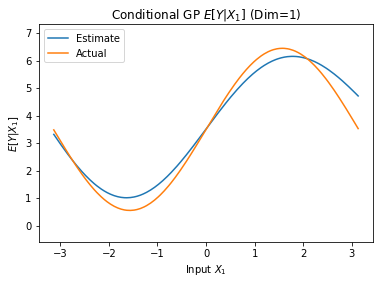

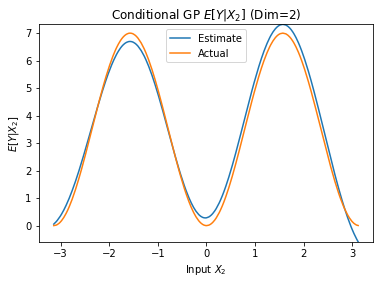

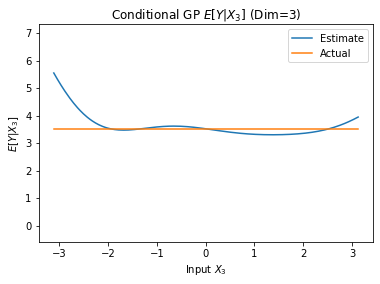

In [10]:
def f1(x):
    return np.sin(x)*(np.pi**4/50+1)+3.5
    
def f2(x):
    return 7*np.sin(x)**2
    
def f3(x3):
    return [3.5]*x3.shape[0]

si.plot_conditional_gp(actual_function=[f1, f2, f3])

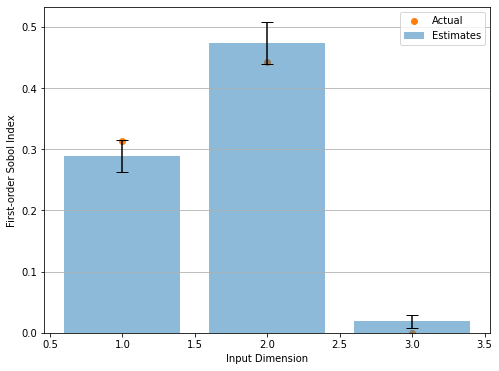

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(3)+1, si.sobol_mean, yerr=si.sobol_std, label='Estimates', capsize=6, alpha=0.5)
ax.scatter(np.arange(3)+1, true_si, label='Actual')
plt.xlabel('Input Dimension')
plt.ylabel('First-order Sobol Index')
ax.yaxis.grid(True)
plt.legend()
plt.show()

In [12]:
def anaylitical_int(s_t=None, kg_=None, k__=None, l_=None, u_=None, sam_std=None, **kwargs):
    len_scale = kg_.corr_model_params[k__]
    tmp1 = stats.norm.cdf((l_ - s_t)*np.sqrt(2*len_scale))
    tmp2 = stats.norm.cdf((u_ - s_t)*np.sqrt(2*len_scale))
    return (1/np.sqrt(4*np.pi*len_scale))*(tmp2-tmp1)*kg_.sample_std[k__]


def anaylitical_dbl_int(kg_=None, k__=None, l_=None, u_=None, sam_std=None, **kwargs):
    len_scale = kg_.corr_model_params[k__]
    constant = kg_.sample_std[k__] ** 2 / (4 * np.pi * np.sqrt(np.pi * len_scale))
    tmp = stats.norm.cdf((u_ - l_) * np.sqrt(2 * len_scale))
    tmp1 = u_ + l_
    tmp2 = 2 * l_ * tmp
    tmp3 = 2 * u_ * (1 - tmp)
    tmp4 = (1 / np.sqrt(np.pi * len_scale)) * (1 - np.exp(-len_scale * (u_ - l_) ** 2))
    return constant * (tmp1 - tmp2 - tmp3 - tmp4)

## 2. Normalized data and Actual Intergration

In [13]:
s_object = SobolKriging(surr_object=krig, dist_object=marginals, n_randv=200, n_sim=1000, single_int=anaylitical_int,
                        double_int=anaylitical_dbl_int, random_state=0)
s_object.run(samples=samples)

(Total variance) MCS estimate:  12.585045649569727
Sobol Indices (using MCS estimate of variance):  [0.2494864045590816, 0.4431221005334143, 0.018334291930550563]


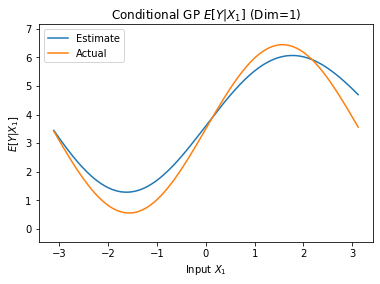

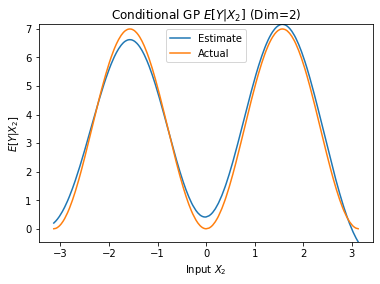

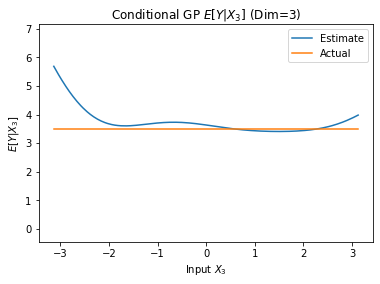

In [14]:
s_object.plot_conditional_gp(actual_function=[f1, f2, f3])

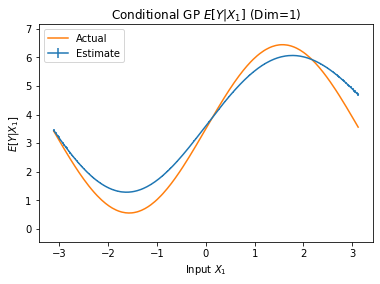

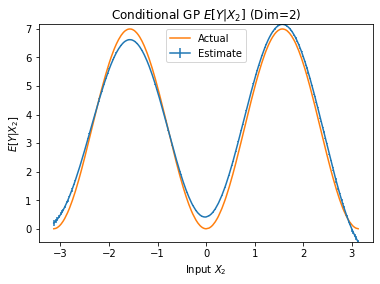

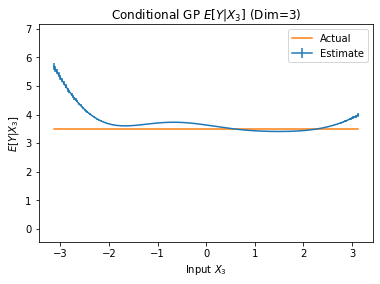

In [15]:
s_object.plot_conditional_gp(actual_function=[f1, f2, f3], err_bar=1)

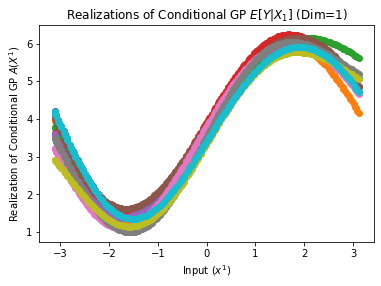

<Figure size 432x288 with 0 Axes>

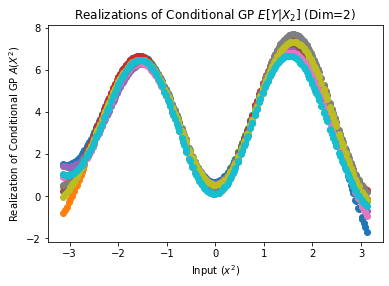

<Figure size 432x288 with 0 Axes>

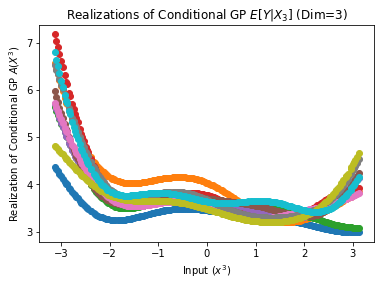

<Figure size 432x288 with 0 Axes>

In [16]:
s_object.plot_gp_realization(n_realization=10)

## 3. No Normalized data and Numerical Intergration

In [17]:
krig1 = Kriging(reg_model='Linear', corr_model='Gaussian', corr_model_params=[1, 1, 1], n_opt=100, bounds=[[0.01, 3]]*3, 
                normalize=False)
krig1.fit(samples=samples, values=values)
print(r"Hyperparameter ($\theta$): ", np.round(krig1.corr_model_params, 3))

Hyperparameter ($\theta$):  [0.089 0.298 0.16 ]


In [18]:
# Compute Validation Error using UQpy
err = ErrorEstimation(surr_object=krig1)
print('Validation Error: ', round(err.validation(test_samples, test_values), 4))

Validation Error:  0.1085


In [19]:
s_object1 = SobolKriging(surr_object=krig1, dist_object=marginals, random_state=2, lower_bound=0, upper_bound=1)
s_object1.run(samples=samples)

(Total variance) MCS estimate:  12.661192837557184
Sobol Indices (using MCS estimate of variance):  [0.28740433029892964, 0.47330970236383874, 0.01927852576705807]


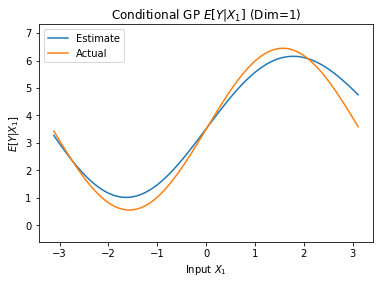

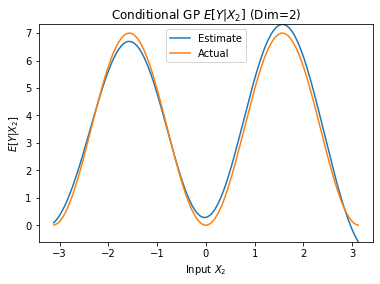

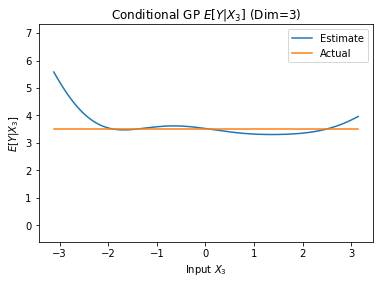

In [20]:
s_object1.plot_conditional_gp(actual_function=[f1, f2, f3])

In [21]:
mcs_samples = MCS(dist_object=marginals, nsamples=100000).samples
np.var(krig1.predict(mcs_samples))

12.559779045540122

In [22]:
np.var(krig.predict(mcs_samples))

12.559778533998118

In [23]:
np.var(ishigami(mcs_samples))

13.75389611251485

## 4. No Normalized data and Actual Intergration

In [24]:
s_object12 = SobolKriging(surr_object=krig1, dist_object=marginals, random_state=2, single_int=anaylitical_int,
                        double_int=anaylitical_dbl_int)
s_object12.run(samples=samples)

(Total variance) MCS estimate:  12.661192837557184
Sobol Indices (using MCS estimate of variance):  [0.2487710757785203, 0.4386515413417568, 0.019036202126190362]


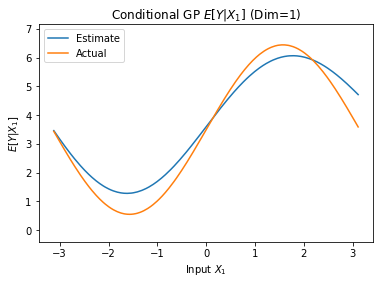

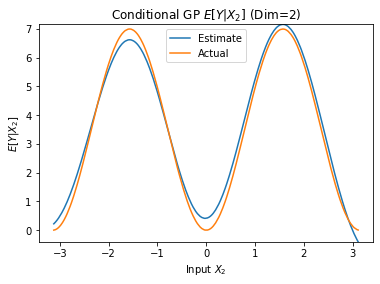

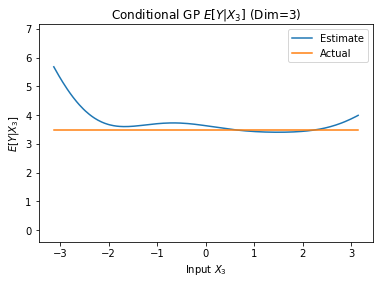

In [25]:
s_object12.plot_conditional_gp(actual_function=[f1, f2, f3])

In [26]:
krig.normalize

True

In [27]:
krig1.normalize

False

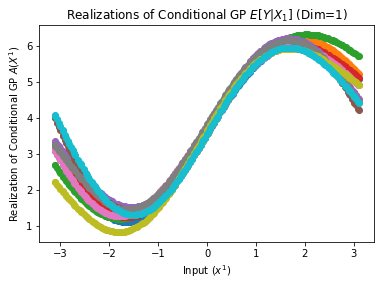

<Figure size 432x288 with 0 Axes>

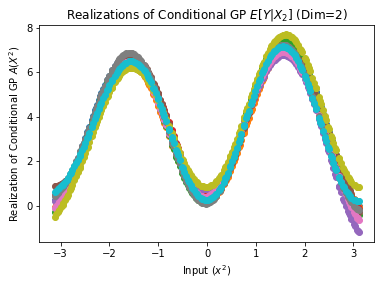

<Figure size 432x288 with 0 Axes>

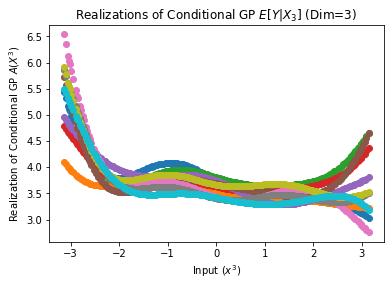

<Figure size 432x288 with 0 Axes>

In [28]:
s_object12.plot_gp_realization(n_realization=10)